In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
from Utils.data_generator import get_onehot
import math
import pickle
from sklearn.preprocessing import MinMaxScaler

## Pre-Process

In [9]:
# BF = pd.read_csv("Data/Batting_First.csv")
# BS = pd.read_csv("Data/Chasing.csv")
# set_venue = set()
# set_players = set()
# set_teams = set()
# for df in [BS, BF]:
#     for col in ["Striker", "Non_Striker", "Bowler"]:
#         set_players = set_players.union(set(df[col]))
#     for col in ["Batting_Team", "Bowling_Team", "Toss"]:
#         set_teams = set_teams.union(set(df[col]))
#     for col in ["Venue"]:
#         set_venue = set_venue.union(set(df[col]))
# with open("Data/Players.pkl", "wb") as fp:
#     pickle.dump(sorted(list(set_players)), fp)
# with open("Data/Teams.pkl", "wb") as fp:
#     pickle.dump(sorted(list(set_teams)), fp)
# with open("Data/Venue.pkl", "wb") as fp:
#     pickle.dump(sorted(list(set_venue)), fp)

## Batting First

In [2]:
BF = pd.read_csv("Data/Batting_First.csv")
# BF = BF.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
#                             "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
print(BF.columns)

Index(['Toss', 'Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score',
       'Wickets', 'Overs', 'Balls', 'Striker', 'Striker_Runs', 'Striker_Balls',
       'Non_Striker', 'Non_Striker_Runs', 'Non_Striker_Balls', 'Bowler',
       'Bowler_Runs', 'Bowler_Overs', 'Bowler_Balls', 'Bowler_Wickets',
       'Free_Hit', 'Result'],
      dtype='object')


In [3]:
x_df, y_df = get_onehot(BF)
num_inp_cols = x_df.shape[-1]
print(x_df.shape)
with open("Data/BF_Cols.pkl", "wb") as fp:
    pickle.dump(list(x_df.columns), fp)

(98040, 1879)


In [5]:
# model_inn_1 = tf.keras.Sequential([
#   tf.keras.layers.InputLayer(input_shape=(num_inp_cols,)),
#   tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(57, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), activation='softmax')
# ])
# model_inn_1.summary()

In [10]:
model_inn_1 = tf.keras.models.load_model('Models\Inn1-HeavyDense-ep20to50\cp-0029.h5')
model_inn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1925120   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               2

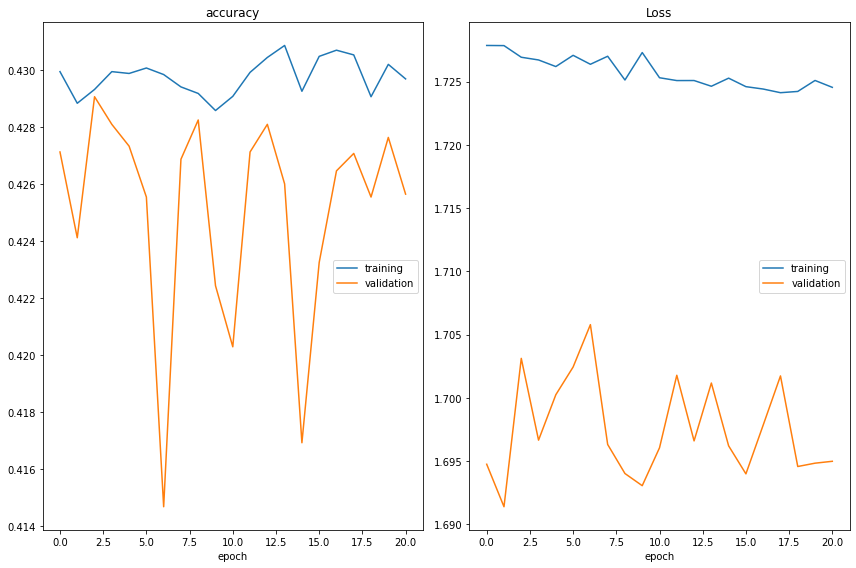

accuracy
	training         	 (min:    0.429, max:    0.431, cur:    0.430)
	validation       	 (min:    0.415, max:    0.429, cur:    0.426)
Loss
	training         	 (min:    1.724, max:    1.728, cur:    1.725)
	validation       	 (min:    1.691, max:    1.706, cur:    1.695)
2451/2451 [==============================] - 51s 21ms/step - loss: 1.7245 - accuracy: 0.4297 - val_loss: 1.6950 - val_accuracy: 0.4256


In [11]:
start = 70
epochs = 30
model_name = "Inn1-HeavyDense"
checkpoint_path_1 = ("Models/"+model_name+f"-ep{start}to{start+epochs}/"
                     "cp-{epoch:04d}.h5")
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_1)
model_inn_1.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00015))
history = model_inn_1.fit(x_df.values, y_df.values,
                epochs=epochs,
                validation_split=0.2,
                callbacks=[model_checkpoint_callback_1, PlotLossesKeras()]
                )
with open(f"Models/"+model_name+f"-ep{start}to{start+epochs}/history.pkl", "wb") as fp:
    pickle.dump(history.history, fp)

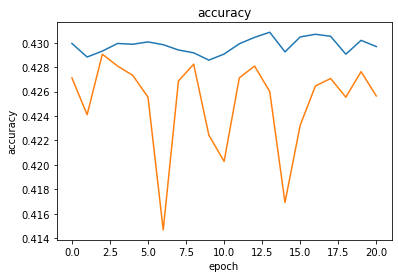

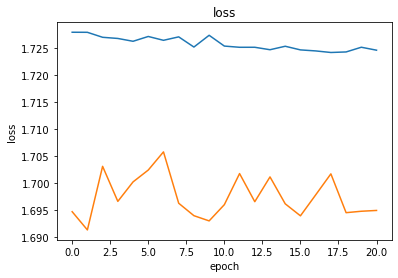

In [12]:
history_val_callback = history.history
for key in sorted([i for i in history_val_callback if i.split("_")[0]!="val"]):
    plt.plot(history_val_callback[key])
    plt.plot(history_val_callback["val_"+key])
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.show()

## Chasing

In [2]:
# del bf_train_gen, bf_test_gen
BS = pd.read_csv("Data/Chasing.csv")
# BS = BS.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
#                             "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
BS["Required_Runs"] = BS["Target"] - BS["Current_Score"]
BS.drop('Target', axis=1, inplace=True)
print(BS.columns)

Index(['Toss', 'Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score',
       'Wickets', 'Overs', 'Balls', 'Striker', 'Striker_Runs', 'Striker_Balls',
       'Non_Striker', 'Non_Striker_Runs', 'Non_Striker_Balls', 'Bowler',
       'Bowler_Runs', 'Bowler_Overs', 'Bowler_Balls', 'Bowler_Wickets',
       'Free_Hit', 'Result', 'Required_Runs'],
      dtype='object')


In [3]:
x_df, y_df = get_onehot(BS)
# scaler = MinMaxScaler()
# arr_scaled = scaler.fit_transform(x_df)
# x_df_scaled = pd.DataFrame(arr_scaled, columns=x_df.columns,index=x_df.index)
num_inp_cols = x_df.shape[-1]
print(x_df.shape)
with open("Data/BS_Cols.pkl", "wb") as fp:
    pickle.dump(list(x_df.columns), fp)

(92016, 1880)


In [4]:
# x_df.loc[:, ['Current_Score',
x_df.loc[:, ['Current_Score',
       'Wickets', 'Overs', 'Balls', 'Striker_Runs', 'Striker_Balls', 'Non_Striker_Runs', 'Non_Striker_Balls',
       'Bowler_Runs', 'Bowler_Overs', 'Bowler_Balls', 'Bowler_Wickets',
       'Free_Hit', 'Required_Runs']].describe()

,Current_Score,Wickets,Overs,Balls,Striker_Runs,Striker_Balls,Non_Striker_Runs,Non_Striker_Balls,Bowler_Runs,Bowler_Overs,Bowler_Balls,Bowler_Wickets,Free_Hit,Required_Runs
count,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000,92016.000000
mean,71.902506,2.291515,9.947498,3.607775,16.544949,13.055882,16.248098,13.068412,12.075976,1.249457,2.473211,0.402973,0.003575,94.488459
std,46.596671,2.089682,5.562803,1.806583,17.655624,11.865243,17.357429,11.839517,9.766426,1.078891,1.706943,0.680751,0.059689,49.947510
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000
25%,33.000000,1.000000,5.000000,2.000000,3.000000,4.000000,3.000000,4.000000,4.000000,0.000000,1.000000,0.000000,0.000000,55.000000
50%,69.000000,2.000000,10.000000,4.000000,11.000000,10.000000,10.000000,10.000000,10.000000,1.000000,2.000000,0.000000,0.000000,94.000000
75%,107.000000,4.000000,15.000000,5.000000,25.000000,19.000000,24.000000,19.000000,18.000000,2.000000,4.000000,1.000000,0.000000,132.000000
max,228.000000,9.000000,20.000000,10.000000,121.000000,69.000000,121.000000,65.000000,68.000000,7.000000,5.000000,5.000000,1.000000,264.000000


In [5]:
# import joblib
# scaler_filename = "Data/BS_Scaler.save"
# joblib.dump(scaler, scaler_filename) 

# And now to load...

# scaler = joblib.load(scaler_filename)

In [6]:
model_inn_2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(num_inp_cols,)),
  tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(57, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), activation='softmax')
])
model_inn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1926144   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               2

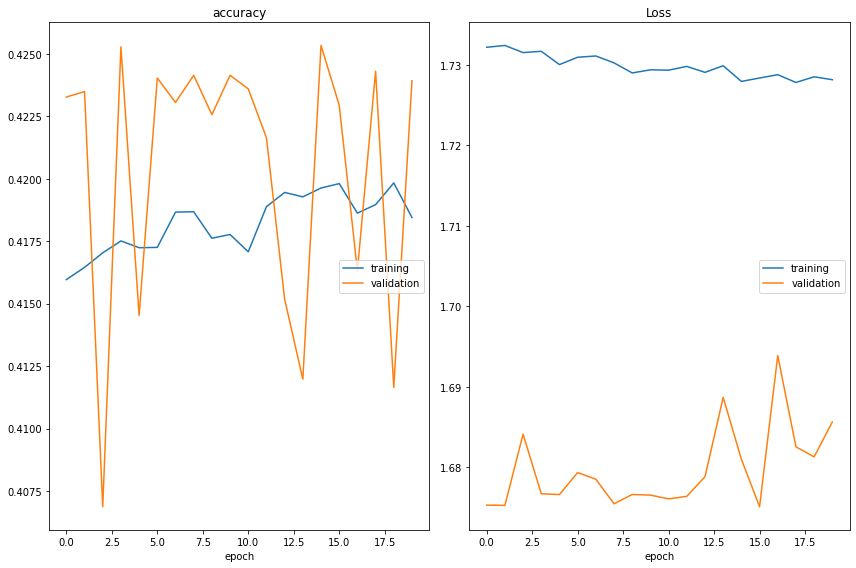

accuracy
	training         	 (min:    0.416, max:    0.420, cur:    0.418)
	validation       	 (min:    0.407, max:    0.425, cur:    0.424)
Loss
	training         	 (min:    1.728, max:    1.732, cur:    1.728)
	validation       	 (min:    1.675, max:    1.694, cur:    1.686)
2301/2301 [==============================] - 51s 22ms/step - loss: 1.7282 - accuracy: 0.4185 - val_loss: 1.6856 - val_accuracy: 0.4239


In [10]:
start = 30
epochs = 20
model_name = "Inn2-HeavyDenseRequired"
checkpoint_path_1 = ("Models/"+model_name+f"-ep{start}to{start+epochs}/"
                     "cp-{epoch:04d}.h5")
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_1)
model_inn_2.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00015))
history = model_inn_2.fit(x_df.values, y_df.values,
                epochs=epochs,
                validation_split=0.2,
                callbacks=[model_checkpoint_callback_1, PlotLossesKeras()]
                )
with open(f"Models/"+model_name+f"-ep{start}to{start+epochs}/history.pkl", "wb") as fp:
    pickle.dump(history.history, fp)

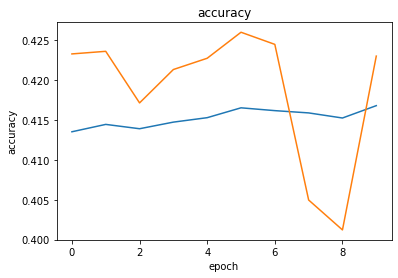

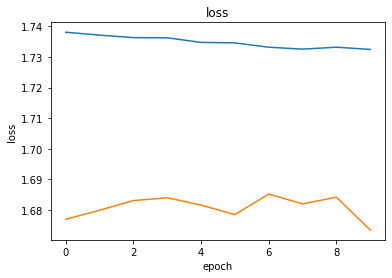

In [14]:
with open("Models\Inn2-HeavyDenseRequired-ep20to30\history.pkl", "rb") as fp:
    history_val_callback = pickle.load(fp)
# history_val_callback = history.history
for key in sorted([i for i in history_val_callback if i.split("_")[0]!="val"]):
    plt.plot(history_val_callback[key])
    plt.plot(history_val_callback["val_"+key])
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.show()

## Visualization

In [10]:
import re
cont = 0
with open("Models\\Inn2-NewSimpleRNN-ep0to20\\progress.txt") as fp:
    txt_file = fp.read()
pat = re.compile(r"Epoch \d+/\d+\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*) - val_loss: (\d+\.?\d*) - val_accuracy: (\d+\.?\d*)"
                 )
matches = re.findall(pat, txt_file)
if not cont:
    history = {"val_loss_1to5": [],
            "val_accuracy_1to5": [],
            "val_loss_6to10": [],
            "val_accuracy_6to10": [],
            "val_loss_11to15": [],
            "val_accuracy_11to15": [],
            "val_loss_16to20": [],
            "val_accuracy_16to20": [],
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
            }
val_overs = ((1, 5), (6, 10), (11, 15), (16, 20))
for ep in matches:
    for ind, (start, end) in enumerate(val_overs):
        history[f"val_loss_{start}to{end}"].append(float(ep[ind*2]))
        history[f"val_accuracy_{start}to{end}"].append(float(ep[ind*2 + 1]))
    history[f"train_loss"].append(float(ep[8]))
    history[f"train_accuracy"].append(float(ep[9]))
    history[f"val_loss"].append(float(ep[10]))
    history[f"val_accuracy"].append(float(ep[11]))

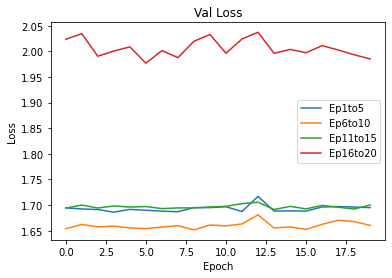

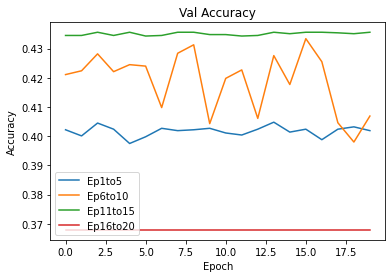

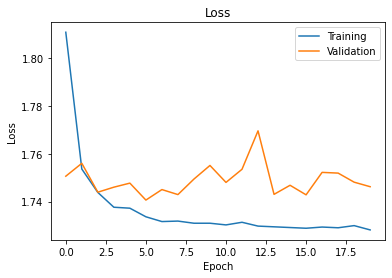

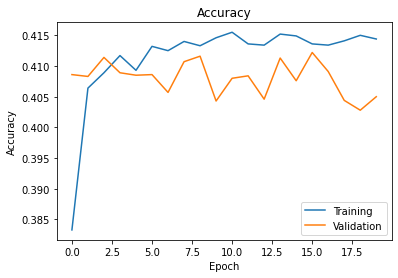

In [11]:
for (start, end) in val_overs:
    plt.plot(history[f"val_loss_{start}to{end}"], label=f"Ep{start}to{end}")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Val Loss")
plt.show()

for (start, end) in val_overs:
    plt.plot(history[f"val_accuracy_{start}to{end}"], label=f"Ep{start}to{end}")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title("Val Accuracy")
plt.show()

plt.plot(history["train_loss"], label="Training")
plt.plot(history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

plt.plot(history["train_accuracy"], label="Training")
plt.plot(history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()